<a href="https://colab.research.google.com/github/yashv04/Prediction-Model/blob/main/Win_Prediction_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max.colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [ ]:
df = pd.read_csv('ball by ball 2024.csv')
df.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN


To build our Win Probability Model, we need to compute:
Total score up to each ball
Wickets fallen
Target runs (2nd innings only)
Balls remaining
Required run rate
Current run rate

In [ ]:
#Calculate cumulative runs and wickets

df['cumulative_runs'] = df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
df['cumulative_wickets'] = df.groupby(['match_id', 'inning'])['is_wicket'].cumsum()


In [ ]:
#Filter only 2nd innings data
df_second_innings = df[df['inning'] == 2].copy()

In [ ]:
# Balls bowled so far
df_second_innings['ball_number'] = (df_second_innings['over'] * 6) + df_second_innings['ball']

# Total balls in an inning (T20) = 120
df_second_innings['balls_remaining'] = 120 - df_second_innings['ball_number']

# Runs remaining will be calculated after we find the target per match

In [ ]:
#Calculate target score
first_innings = df[df['inning'] == 1].groupby('match_id')['total_runs'].sum().reset_index()
first_innings.columns = ['match_id', 'target_score']
first_innings['target_score'] += 1  # chasing team must exceed this to win

# Merge with second innings
df_second_innings = df_second_innings.merge(first_innings, on='match_id', how='left')

# Runs required
df_second_innings['runs_remaining'] = df_second_innings['target_score'] - df_second_innings['cumulative_runs']

In [ ]:
# Calculate balls played so far
df_second_innings['balls_played'] = 120 - df_second_innings['balls_remaining']

# CRR: Current Run Rate
df_second_innings['crr'] = (df_second_innings['cumulative_runs'] / df_second_innings['balls_played']) * 6
df_second_innings['crr'] = df_second_innings['crr'].fillna(0)

# RRR: Required Run Rate
df_second_innings['rrr'] = (df_second_innings['runs_remaining'] / df_second_innings['balls_remaining']) * 6
df_second_innings['rrr'] = df_second_innings['rrr'].replace([float('inf'), -float('inf')], 0).fillna(0)

 Add the Win/Loss Outcome Label

In [ ]:
final_runs = df_second_innings.groupby('match_id')['cumulative_runs'].max().reset_index()
final_runs.columns = ['match_id', 'final_score']

In [ ]:
# Merge with target
final_df = final_runs.merge(first_innings, on='match_id')

# Label as 1 if final_score >= target_score (win)
final_df['won'] = (final_df['final_score'] >= final_df['target_score']).astype(int)

In [ ]:
df_second_innings = df_second_innings.merge(final_df[['match_id', 'won']], on='match_id', how='left')

Model Training – Win Probability Predictor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Select features and target
features = ['runs_remaining', 'balls_remaining', 'cumulative_wickets', 'crr', 'rrr']
X = df_second_innings[features]
y = df_second_innings['won']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of winning

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8208676289315678
ROC AUC Score: 0.9086748873111475
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     12321
           1       0.82      0.83      0.82     12828

    accuracy                           0.82     25149
   macro avg       0.82      0.82      0.82     25149
weighted avg       0.82      0.82      0.82     25149



In [ ]:
# Example:
sample_input = pd.DataFrame({
    'runs_remaining': [80],
    'balls_remaining': [30],
    'cumulative_wickets': [3],
    'crr': [12],
    'rrr': [16]
})

win_prob = model.predict_proba(sample_input)[0][1]
print("Predicted Win Probability: {:.2f}%".format(win_prob * 100))

Predicted Win Probability: 2.00%


In [ ]:
df.match_id.unique()

array([ 335982,  335983,  335984, ..., 1426310, 1426311, 1426312])



Plotting Win Probability Over a Match Timeline

In [ ]:
1426310 == df_second_innings['match_id'].value_counts().index[0]  # most data
match_df = df_second_innings[df_second_innings['match_id'] == 1426310].copy()

In [ ]:
# Use model to predict probability of winning for each ball
match_df['win_probability'] = model.predict_proba(match_df[features])[:, 1]

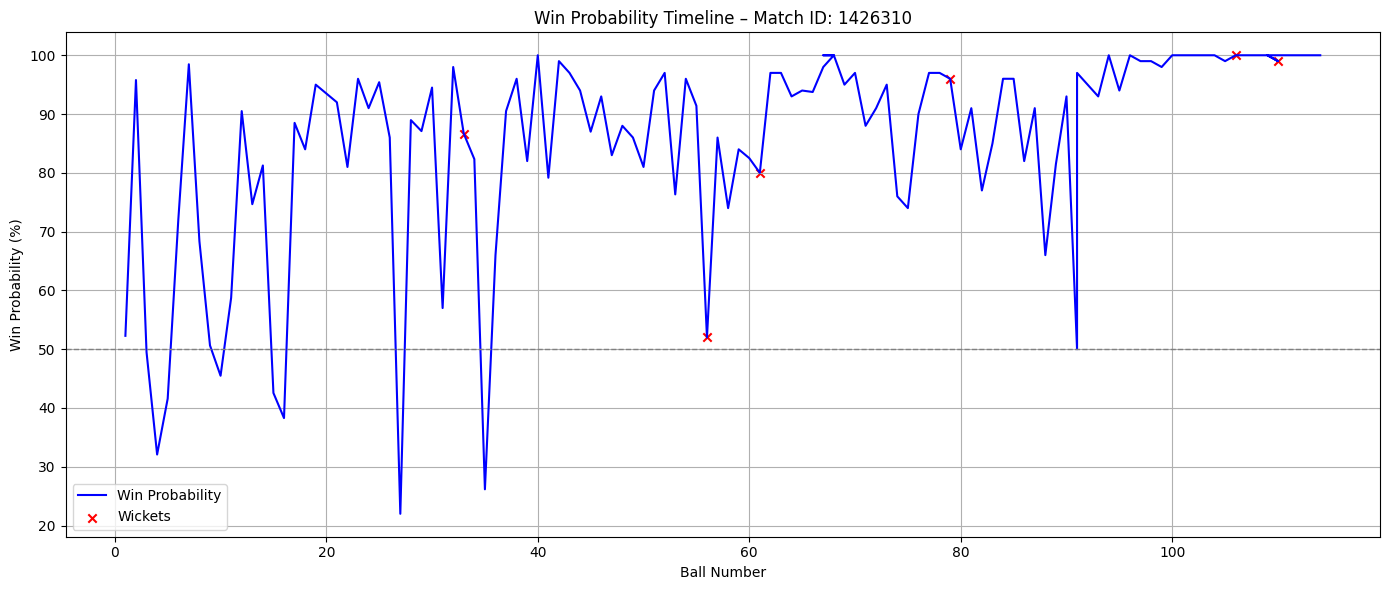

In [ ]:
import matplotlib.pyplot as plt

# Create a timeline index for the x-axis (ball-by-ball)
match_df['ball_no'] = match_df['over'] * 6 + match_df['ball']

plt.figure(figsize=(14, 6))
plt.plot(match_df['ball_no'], match_df['win_probability'] * 100, label='Win Probability', color='blue')
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1)

# Mark key moments
wickets = match_df[match_df['is_wicket'] == 1]
plt.scatter(wickets['ball_no'], wickets['win_probability'] * 100, color='red', label='Wickets', marker='x')

plt.title(f'Win Probability Timeline – Match ID: {1426310}')
plt.xlabel('Ball Number')
plt.ylabel('Win Probability (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Build Streamlit App for Win Probability

In [30]:
!pip install gradio

In [32]:
import gradio as gr
import joblib
import pandas as pd

model = joblib.load("win_predictor_model.pkl")

def predict(runs, balls, wickets, crr, rrr):
    df = pd.DataFrame({
        'runs_remaining': [runs],
        'balls_remaining': [balls],
        'cumulative_wickets': [wickets],
        'crr': [crr],
        'rrr': [rrr]
    })
    prob = model.predict_proba(df)[0][1] * 100
    return f"{prob:.2f}%"

gr.Interface(
    fn=predict,
    inputs=["number", "number", "number", "number", "number"],
    outputs="text",
    title="Win Probability Predictor"
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9af39b9ce8ce7beb93.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


This model predicts the win probability of a cricket team during a T20 match. It's like a fortune teller for cricket, using live match data to calculate the chances of victory.

Imagine a nail-biting chase, runs needed, wickets falling, time ticking away. This model crunches the numbers – current run rate, required run rate, wickets lost – to provide a real-time win probability.

It's not magic, but a powerful tool using machine learning. Trained on past matches, it understands the ebb and flow of T20 cricket, providing insights into the game's unpredictable nature.